<a href="https://colab.research.google.com/github/LuchoVidalSMN/CursoAECID/blob/main/Practica_N%C2%B01_Explorando_los_datos_de_radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

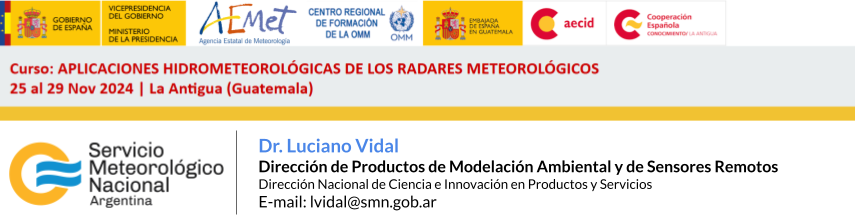

---
# **Práctica N°1:** Explorando datos de radar en diferentes formatos
Los datos de radar meteorologicos puede generarse en diferentes formatos que generalmente dependen en gran medida del fabricante del radar, siempre que hablemos de los daros más crudos del radar. Luego, cuando uno realiza un posprocesamiento de los datos (ej., generar un CAPPI o calcular lluvia), esa salida uno puede elegir en qué formato guardarlo.
En esta pŕactica vamos a explorar 3 formatos de datos:


* NetCDF/CF-Radial
* Gematronik VOL
* EEC HDF5

El **objetivo** entonces es que ustedes puedan familiarizarse con la información que continenen los archivos y poder generar visualizaciones simples de diferentes variables como la reflectividad o el coeficiente de correlación co-polar.

## *¡Comencemos!* 💪
---

# **Instalación de librerías**
Si bien la herramienta Google Colaboratory trae un gran número de librerías preinstaladas, otras más específicas para el manejo de datos radar como [Py-ART](https://arm-doe.github.io/pyart/) no lo estan, y entonces tenemos que instalarlas. También algunas otras librerías que serán muy útiles al momento de graficar y querer agregar mapas y jugar con proyecciones como [Cartopy](https://scitools.org.uk/cartopy/docs/latest/).

In [ ]:

!pip install -qq --upgrade pip
!pip install -qq fsspec==2023.6.0
!pip install -qq pyproj
!pip install -qq netCDF4
!pip install -qq arm-pyart
!apt-get install -qq libgdal-dev libproj-dev
!pip install -qq --force-reinstall --no-binary shapely shapely==1.7.1
!pip install -qq cartopy==0.21
!pip install -qq glob2
!pip install -qq --user urllib3>=1.25
!pip install -qq wradlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 66.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2023.6.0 requires fsspec==2023.6.0,

# **Descarga de datos**
Vamos a descargar los tres archivos a trabajar y para ello vamos a usar el comando *wget*, que los gaurdará en el disco local de la Google Colab (la nube!).

In [ ]:

# ARCHIVO FORMATO NETCDF/CF-RADIAL
file_nc = 'cfrad.20231029_230952.0000_to_20231029_231540.0000_RMA4_0200_01.nc'
!wget -O file.nc https://www.dropbox.com/scl/fi/7rbt8ed2a7a6w8pp7n1bi/cfrad.20231029_230952.0000_to_20231029_231540.0000_RMA4_0200_01.nc?rlkey=owhb6jltujkun4p0anqvi4ahn&dl=0

# ARCHIVO FORMATO VOL
file_vl = '2019100123200700dBZ.vol'
!wget -O file.vol https://www.dropbox.com/scl/fi/x2688yvcqcomi4h6rzeql/2019100123200700dBZ.vol?rlkey=draui6kazfslfuj6mcqtffcts&dl=0

# ARCHIVO FORMATO HDF5
file_h5 = 'SRM-PPIVol-20220329-195858-03b6.hdf'
!wget -O file.hdf https://www.dropbox.com/scl/fi/9patrgn4tj4sakklsbjpb/SRM-PPIVol-20220329-195858-03b6.hdf?rlkey=m0wej403qu848g5p2ljqoj4rv&dl=0


--2023-10-31 19:48:01--  https://www.dropbox.com/scl/fi/7rbt8ed2a7a6w8pp7n1bi/cfrad.20231029_230952.0000_to_20231029_231540.0000_RMA4_0200_01.nc?rlkey=owhb6jltujkun4p0anqvi4ahn
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucca13bcf739196e506bff43fb85.dl.dropboxusercontent.com/cd/0/inline/CGq8-ysig0keTJQ_65TMHXWEqkuwhmiu4rjBUqlDpM23J0LczJEZ_TdfcYYGgqeUqupDRnnmeplpCT6hOOgboybMedCUNVvOt3qc7g9Q3kHMOuNwLL8YOPmyf3lbVgaEoKE/file# [following]
--2023-10-31 19:48:03--  https://ucca13bcf739196e506bff43fb85.dl.dropboxusercontent.com/cd/0/inline/CGq8-ysig0keTJQ_65TMHXWEqkuwhmiu4rjBUqlDpM23J0LczJEZ_TdfcYYGgqeUqupDRnnmeplpCT6hOOgboybMedCUNVvOt3qc7g9Q3kHMOuNwLL8YOPmyf3lbVgaEoKE/file
Resolving ucca13bcf739196e506bff43fb85.dl.dropboxusercontent.com (ucca13bcf739196e506bff43fb85.dl.dropboxusercontent.com)... 162.12

# **Importamos las librerías**

In [ ]:

import pyart
import numpy as np
from matplotlib import pyplot as plt



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

0.2.0


# **Procesando archivo en formato NetCDF/CF-Radial**
Tenemos varias librerias que permiten leer este formato de archivos pero por una cuestión práctica vamos a explorar la librería `pyart` ya que esta pensada para el manejo de datos de radar. Existan otras librerías como por ejemplo `wradlib`, pero no la utilizaremoa por ahora.

### 1. Lectura del archivo

In [ ]:
radar = pyart.io.read('file.nc')

### 2. Variables disponibles

In [ ]:
print(radar.fields.keys())

dict_keys(['DBZV', 'DBZH', 'ZDR', 'RHOHV', 'PHIDP'])


### 3. Acceso a las variables y su contenido

In [ ]:
# Datos del sitio radar
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
radar_alt = radar.altitude['data'][0]

# Veamos que valores son ...
print(radar_lat, radar_lon, radar_alt)

-27.45167 -59.05083 91.0


### 4. Elevaciones disponibles (PPI)

In [ ]:
print(radar.fixed_angle['data'].data)

[ 0.53  0.92  1.32  1.8   2.29  3.12  4.    5.1   6.37  8.    9.98 12.48
 15.56 19.95 30.01]


### 5. Accediendo a un dado PPI

Tamaño de la matriz ZH:
(359, 525)
--------------------------------------------------------------------------------
Figura VERSION 1


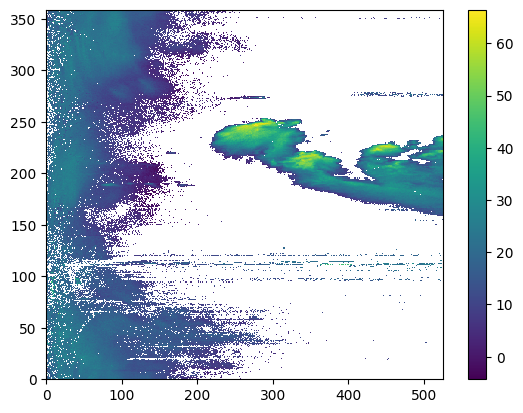

--------------------------------------------------------------------------------
Figura VERSION 2


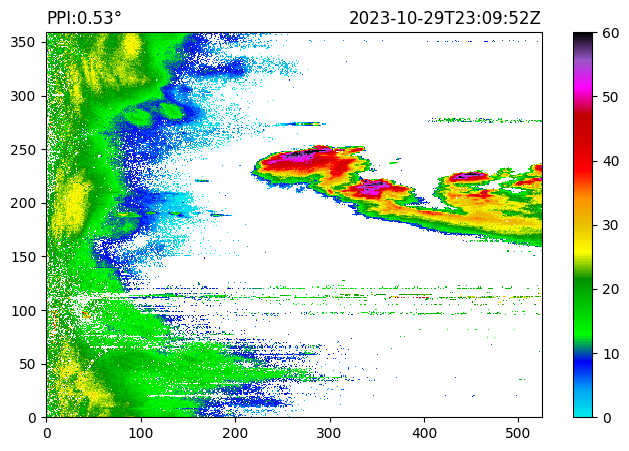

In [ ]:

# Definimos la elevacion de interés (PPI)
nelev=0

# Indices de inicio y fin de PPI (necesarios para lo que sigue)
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]

# Extraemos las coordenadas LAT/LON de los pixeles del PPI
lats_rad = radar.gate_latitude['data'][start_index:end_index]
lons_rad = radar.gate_longitude['data'][start_index:end_index]

# Extraemos los datos de reflectividad horizontal
ZH = radar.fields['DBZH']['data'][start_index:end_index, :]

# ¿Qué dimensiones tiene ZH?
print('Tamaño de la matriz ZH:')
print(ZH.shape)

# ¿Que aspecto tiene? Hagamos un grafico simple ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 1')
plt.pcolormesh(ZH)
plt.colorbar()
plt.show()

# Podemos mejorar un poco la figura ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 2')
plt.figure(figsize=[8,5])
plt.pcolormesh(ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()

# Mas paletas de colores aqui:
# https://arm-doe.github.io/pyart/examples/plotting/plot_choose_a_colormap.html
# https://matplotlib.org/stable/users/explain/colors/colormaps.html


### 6. Mejorando la visualización del PPI

<ipython-input-89-21a580d889cd>:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')


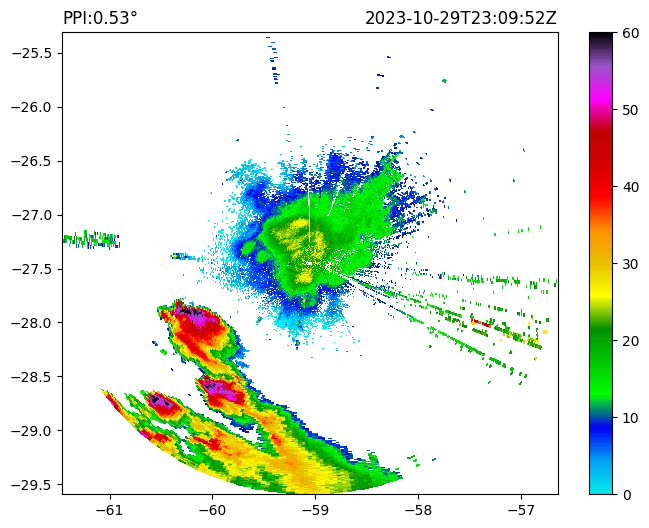

In [ ]:

# Ahora vamos a utilizar las coordenadas de latitud y longitud

plt.figure(figsize=[8,6])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


<ipython-input-100-b4a5c944a4e9>:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')


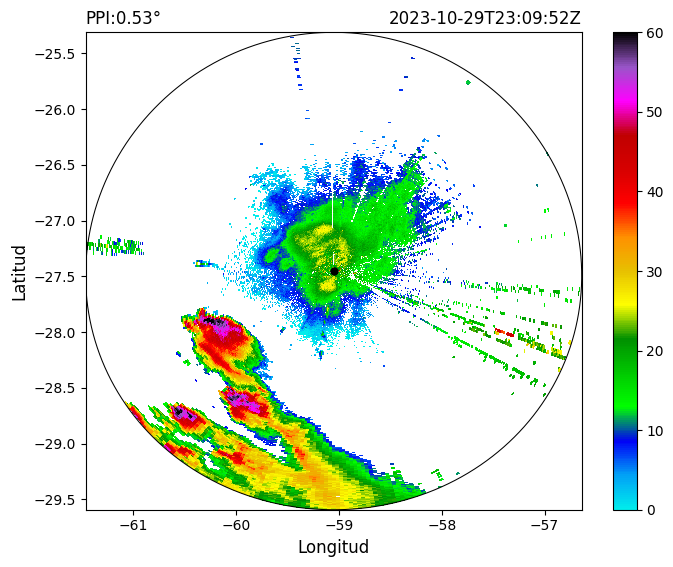

In [ ]:

# Le vamos a sumar un anillo con el alcance máximo asi nos es más fácil
# saber hasta donde esperamos ver datos
rmax=238

R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

plt.figure(figsize=[8,6.2])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.plot(lon_rmax, lat_rmax, 'k', lw=0.75)
plt.plot(radar_lon, radar_lat, 'ok', ms=5)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


# **Procesando archivo en formato VOL**
En este caso utilizaremos nuevamente la librería `pyart`.

### 1. Lectura del archivo

In [ ]:
radar = pyart.aux_io.read_rainbow_wrl('file.vol')

### 2. Variables disponibles

In [ ]:
print(radar.fields.keys())

dict_keys(['reflectivity'])


### 3. Acceso a las variables y su contenido

In [ ]:
# Datos del sitio radar
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
radar_alt = radar.altitude['data'][0]

# Veamos que valores son ...
print(radar_lat, radar_lon, radar_alt)

-31.848438 -60.537289 100.0


### 4. Elevaciones disponibles (PPI)

In [ ]:
print(np.unique(radar.elevation['data']))

[ 0.5  0.9  1.3  1.9  2.3  3.   3.5  5.   6.9  9.1 11.8 15.1]


### 5. Accediendo a un dado PPI

Tamaño de la matriz ZH:
(360, 480)
--------------------------------------------------------------------------------
Figura VERSION 1


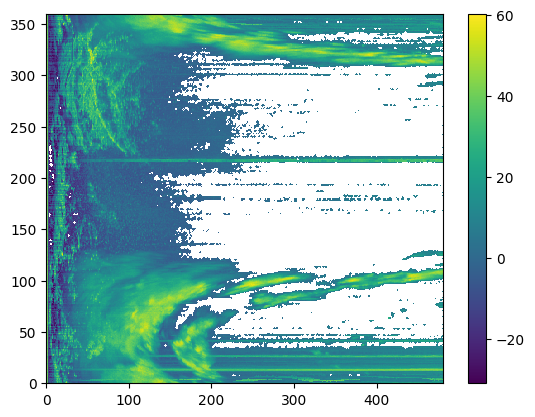

--------------------------------------------------------------------------------
Figura VERSION 2


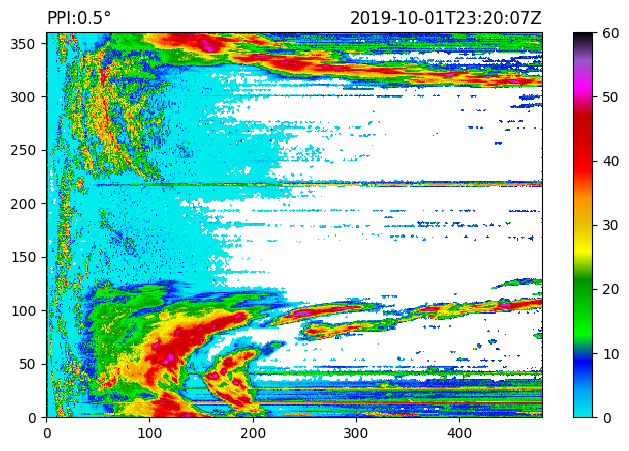

In [ ]:

# Definimos la elevacion de interés (PPI)
nelev=0

# Indices de inicio y fin de PPI (necesarios para lo que sigue)
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]

# Extraemos las coordenadas LAT/LON de los pixeles del PPI
lats_rad = radar.gate_latitude['data'][start_index:end_index]
lons_rad = radar.gate_longitude['data'][start_index:end_index]

# Extraemos los datos de reflectividad horizontal
ZH = radar.fields['reflectivity']['data'][start_index:end_index, :]

# ¿Qué dimensiones tiene ZH?
print('Tamaño de la matriz ZH:')
print(ZH.shape)

# ¿Que aspecto tiene? Hagamos un grafico simple ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 1')
plt.pcolormesh(ZH)
plt.colorbar()
plt.show()

# Podemos mejorar un poco la figura ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 2')
plt.figure(figsize=[8,5])
plt.pcolormesh(ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()

# Mas paletas de colores aqui:
# https://arm-doe.github.io/pyart/examples/plotting/plot_choose_a_colormap.html
# https://matplotlib.org/stable/users/explain/colors/colormaps.html


### 6. Mejorando la visualización del PPI

<ipython-input-31-21a580d889cd>:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')


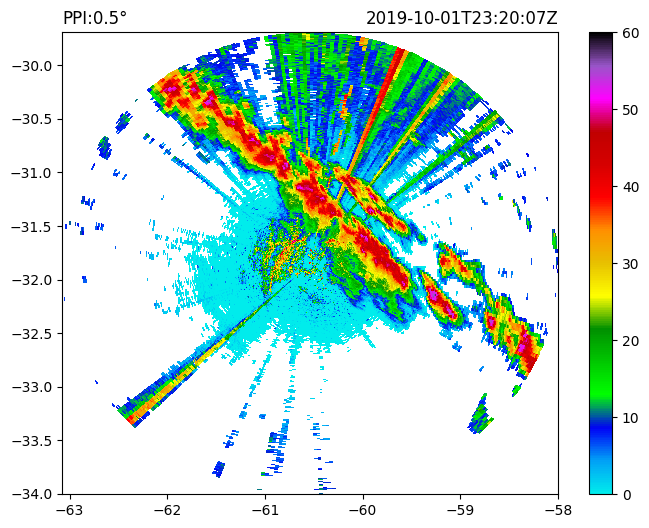

In [ ]:

# Ahora vamos a utilizar las coordenadas de latitud y longitud

plt.figure(figsize=[8,6])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


<ipython-input-32-9c79efe59ed1>:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')


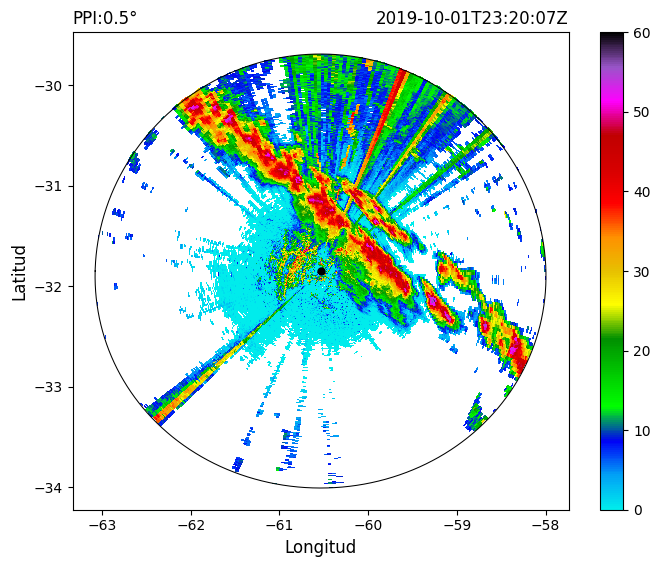

In [ ]:

# Le vamos a sumar un anillo con el alcance máximo asi nos es más fácil
# saber hasta donde esperamos ver datos
rmax=240

R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

plt.figure(figsize=[8,6.2])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.plot(lon_rmax, lat_rmax, 'k', lw=0.75)
plt.plot(radar_lon, radar_lat, 'ok', ms=5)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


# **Procesando archivo en formato HDF5**

### 1. Lectura del archivo

In [ ]:
radar = pyart.aux_io.odim_h5.read_odim_h5('file.hdf')

### 2. Variables disponibles

In [ ]:
for i in radar.fields.keys():
    print(i)

total_power_horizontal
normalized_coherent_power
signal_to_noise_ratio
velocity
spectrum_width
total_power_vertical
reflectivity_horizontal
reflectivity_vertical
differential_reflectivity
cross_correlation_ratio
differential_phase
specific_differential_phase


### 3. Acceso a las variables y su contenido

In [ ]:
# Datos del sitio radar
radar_lat = radar.latitude['data'][0]
radar_lon = radar.longitude['data'][0]
radar_alt = radar.altitude['data'][0]

# Veamos que valores son ...
print(radar_lat, radar_lon, radar_alt)

-34.68145751953125 -58.74660110473633 40.0


### 4. Elevaciones disponibles (PPI)

In [ ]:
print(np.unique(radar.fixed_angle['data']))

[ 0.5  0.9  1.3  1.8  2.4  3.1  4.   5.1  6.4  8.  10.  12.  14.  16.7
 19.5]


### 5. Accediendo a un dado PPI

Tamaño de la matriz ZH:
(359, 3736)
--------------------------------------------------------------------------------
Figura VERSION 1


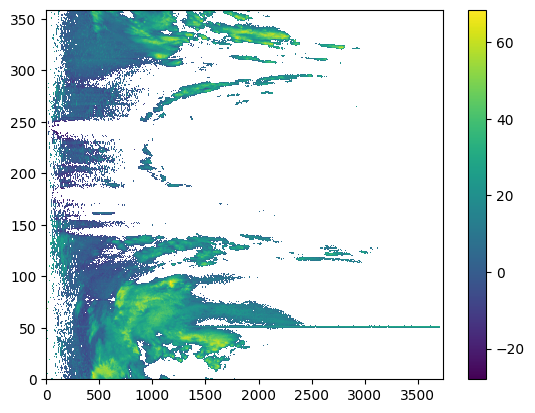

--------------------------------------------------------------------------------
Figura VERSION 2


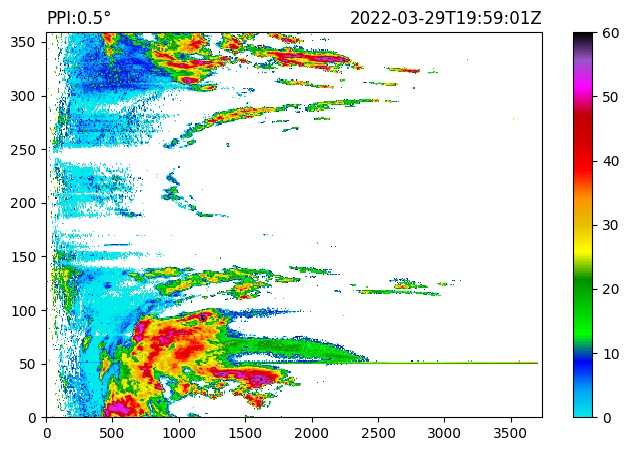

In [ ]:

# Definimos la elevacion de interés (PPI)
nelev=0

# Indices de inicio y fin de PPI (necesarios para lo que sigue)
start_index = radar.sweep_start_ray_index['data'][nelev]
end_index   = radar.sweep_end_ray_index['data'][nelev]

# Extraemos las coordenadas LAT/LON de los pixeles del PPI
lats_rad = radar.gate_latitude['data'][start_index:end_index]
lons_rad = radar.gate_longitude['data'][start_index:end_index]

# Extraemos los datos de reflectividad horizontal
ZH = radar.fields['reflectivity_horizontal']['data'][start_index:end_index, :]

# ¿Qué dimensiones tiene ZH?
print('Tamaño de la matriz ZH:')
print(ZH.shape)

# ¿Que aspecto tiene? Hagamos un grafico simple ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 1')
plt.pcolormesh(ZH)
plt.colorbar()
plt.show()

# Podemos mejorar un poco la figura ...
print('--------------------------------------------------------------------------------')
print('Figura VERSION 2')
plt.figure(figsize=[8,5])
plt.pcolormesh(ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()

# Mas paletas de colores aqui:
# https://arm-doe.github.io/pyart/examples/plotting/plot_choose_a_colormap.html
# https://matplotlib.org/stable/users/explain/colors/colormaps.html


### 6. Mejorando la visualización del PPI

<ipython-input-38-21a580d889cd>:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')


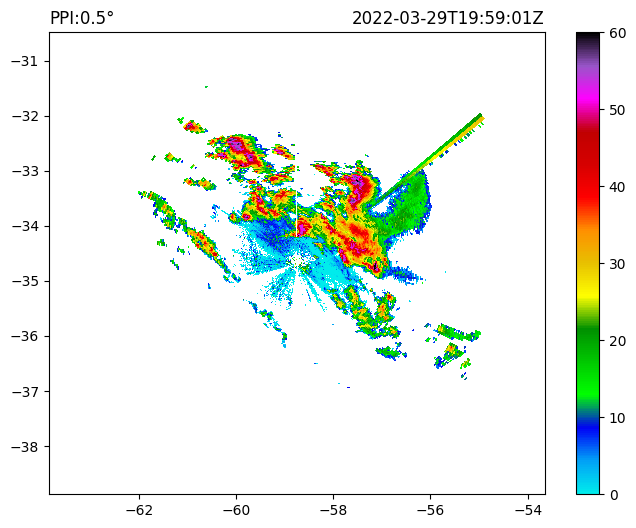

In [ ]:

# Ahora vamos a utilizar las coordenadas de latitud y longitud

plt.figure(figsize=[8,6])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


<ipython-input-50-f37e663797ad>:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')


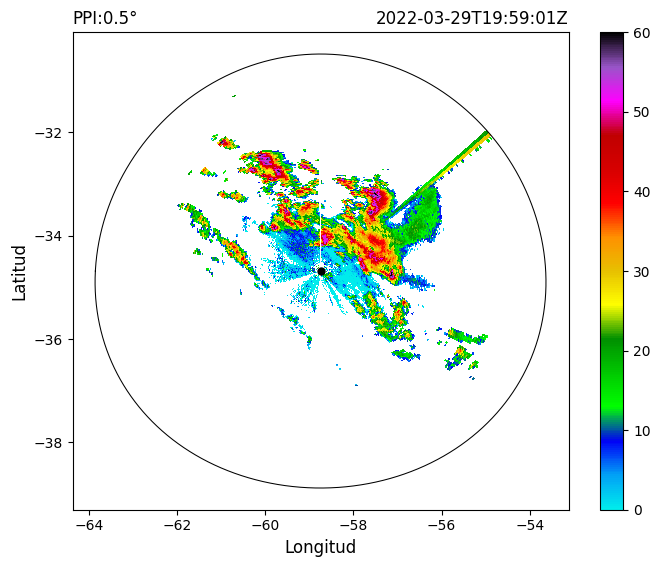

In [ ]:

# Le vamos a sumar un anillo con el alcance máximo asi nos es más fácil
# saber hasta donde esperamos ver datos
rmax = [len(ZH.data[0,:])-np.isnan(ZH.data[0,:]).sum()][0]*radar.range['meters_between_gates']/1000

R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

plt.figure(figsize=[8,6.2])
plt.pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar()
plt.plot(lon_rmax, lat_rmax, 'k', lw=0.75)
plt.plot(radar_lon, radar_lat, 'ok', ms=5)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.title(radar.time['units'][14:], fontsize=12, loc='right')
plt.title('PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=12, loc='left')
plt.show()


### 7. ¿Y le agregamos un mapa y otras cositas?

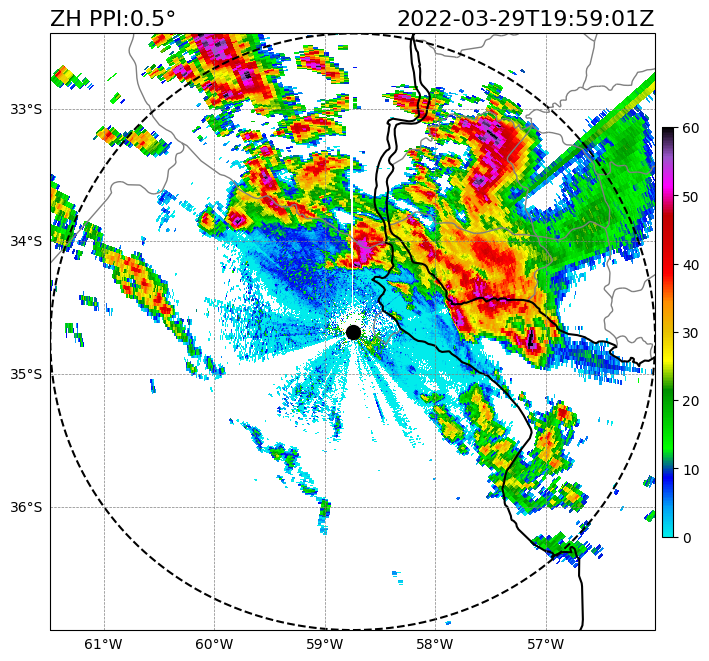

In [ ]:

import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

costas = cartopy.feature.NaturalEarthFeature(
                                             category='physical',
                                             name='coastline',
                                             scale='10m',
                                             facecolor='none'
                                            )

paises = cartopy.feature.NaturalEarthFeature(
                                             category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='none'
                                            )

prov   = cartopy.feature.NaturalEarthFeature(
                                             category='cultural',
                                             name='admin_1_states_provinces_lines',
                                             scale='10m',
                                             facecolor='none'
                                            )

rmax=250.0
R=12742/2 # Radio medio de la Tierra
mm=2*np.pi*R/360
alfa=np.linspace(-np.pi,np.pi,10000)
lat_rmax = np.array([])
lon_rmax = np.array([])
for line in alfa:
  tmp1 = radar_lat + (rmax/mm)*np.sin(line)
  tmp2 = radar_lon + ((rmax/mm)*np.cos(line)/np.cos(tmp1*np.pi/180))
  lat_rmax = np.append(lat_rmax, tmp1)
  lon_rmax = np.append(lon_rmax, tmp2)

fig, ax = plt.subplots(1, 1, figsize=(8,7), subplot_kw={'projection': ccrs.PlateCarree()}, squeeze=False)
fig.patch.set_facecolor('white')
fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.0001, hspace=0.0001)

im=ax[0][0].pcolormesh(lons_rad, lats_rad, ZH, vmin=0, vmax=60, cmap='pyart_NWSRef')
plt.colorbar(im, ax=ax[0][0], aspect=40, pad=0.01, shrink=0.65)

# Agregamos mapa limites politicos
ax[0][0].add_feature(prov, facecolor='None', edgecolor='gray', linewidth=1.0)
ax[0][0].add_feature(paises, facecolor='None', edgecolor='k', linewidth=1.5)

# Grafico el limite exterior de los datos de radar (rmax)
ax[0][0].plot(lon_rmax, lat_rmax, '--k', lw=1.5)

# Graficamos posición sitio radar
ax[0][0].plot(radar_lon, radar_lat, 'ok', ms=10)

# Titulo de la figura
ax[0][0].set_title(radar.time['units'][14:], fontsize=16, loc='right')
ax[0][0].set_title('ZH PPI:'+str(radar.fixed_angle['data'][nelev])+'°', fontsize=16, loc='left')

ax[0][0].set_xlim([lon_rmax.min(), lon_rmax.max()])
ax[0][0].set_ylim([lat_rmax.min(), lat_rmax.max()])

ax[0][0].set_aspect(1.2)

# AGREGAMOS LINES Y MARCAS LAT/LON
gl = ax[0][0].gridlines(
                        crs=ccrs.PlateCarree(),
                        color='gray',
                        linestyle='--',
                        linewidth=0.5,
                        xlocs=np.arange(-180, 180, 1),
                        ylocs=np.arange(-90, 90, 1),
                        draw_labels=True
                       )
gl.top_labels = False
gl.right_labels = False

# Guardamos la figura
plt.savefig('ejemplo.png', transparent=False, bbox_inches='tight')

plt.show()
